In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 

from pybaseball import batting_stats, pitching_stats

In [70]:
import matplotlib as mpl 
mpl.rcParams.update(mpl.rcParamsDefault)

In [2]:
# batting dataset
batting_22_df = batting_stats(2022,qual=300)
print('2022 batting dataset:',batting_22_df.shape)

#pitching dataset
pitching_22_df = pitching_stats(2022,qual=30)
print('2022 pitching dataset:',pitching_22_df.shape)

2022 batting dataset: (277, 320)
2022 pitching dataset: (470, 334)


In [3]:
# every batting stats columns
print(batting_22_df.columns.tolist())

['IDfg', 'Season', 'Name', 'Team', 'Age', 'G', 'AB', 'PA', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP', 'SB', 'CS', 'AVG', 'GB', 'FB', 'LD', 'IFFB', 'Pitches', 'Balls', 'Strikes', 'IFH', 'BU', 'BUH', 'BB%', 'K%', 'BB/K', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'IFH%', 'BUH%', 'wOBA', 'wRAA', 'wRC', 'Bat', 'Fld', 'Rep', 'Pos', 'RAR', 'WAR', 'Dol', 'Spd', 'wRC+', 'WPA', '-WPA', '+WPA', 'RE24', 'REW', 'pLI', 'phLI', 'PH', 'WPA/LI', 'Clutch', 'FB% (Pitch)', 'FBv', 'SL%', 'SLv', 'CT%', 'CTv', 'CB%', 'CBv', 'CH%', 'CHv', 'SF%', 'SFv', 'KN%', 'KNv', 'XX%', 'PO%', 'wFB', 'wSL', 'wCT', 'wCB', 'wCH', 'wSF', 'wKN', 'wFB/C', 'wSL/C', 'wCT/C', 'wCB/C', 'wCH/C', 'wSF/C', 'wKN/C', 'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%', 'Contact%', 'Zone%', 'F-Strike%', 'SwStr%', 'BsR', 'FA% (sc)', 'FT% (sc)', 'FC% (sc)', 'FS% (sc)', 'FO% (sc)', 'SI% (sc)', 'SL% (sc)', 'CU% (sc)', 'KC% (sc)', 'EP% (sc)', 'CH% (

In [4]:
# every pitching stats columns
print(pitching_22_df.columns.tolist())

['IDfg', 'Season', 'Name', 'Team', 'Age', 'W', 'L', 'WAR', 'ERA', 'G', 'GS', 'CG', 'ShO', 'SV', 'BS', 'IP', 'TBF', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK', 'SO', 'GB', 'FB', 'LD', 'IFFB', 'Balls', 'Strikes', 'Pitches', 'RS', 'IFH', 'BU', 'BUH', 'K/9', 'BB/9', 'K/BB', 'H/9', 'HR/9', 'AVG', 'WHIP', 'BABIP', 'LOB%', 'FIP', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'IFH%', 'BUH%', 'Starting', 'Start-IP', 'Relieving', 'Relief-IP', 'RAR', 'Dollars', 'tERA', 'xFIP', 'WPA', '-WPA', '+WPA', 'RE24', 'REW', 'pLI', 'inLI', 'gmLI', 'exLI', 'Pulls', 'WPA/LI', 'Clutch', 'FB% 2', 'FBv', 'SL%', 'SLv', 'CT%', 'CTv', 'CB%', 'CBv', 'CH%', 'CHv', 'SF%', 'SFv', 'KN%', 'KNv', 'XX%', 'PO%', 'wFB', 'wSL', 'wCT', 'wCB', 'wCH', 'wSF', 'wKN', 'wFB/C', 'wSL/C', 'wCT/C', 'wCB/C', 'wCH/C', 'wSF/C', 'wKN/C', 'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%', 'Contact%', 'Zone%', 'F-Strike%', 'SwStr%', 'HLD', 'SD', 'MD', 'ERA-', 'FIP-', 'xFIP-', 'K%', 'BB%', 'SIERA', 'RS/9', 'E-F', 'FA% (

In [127]:
# stats columns
bat_stats = ['IDfg','Season','Name','Team','Age','G','AB','PA','H','HR','R','RBI','BB','SO','SB','AVG','OBP','SLG','OPS','wOBA','wRC+','WAR']
bat_adv_stats = ['IDfg','Season','Name','Team','Age','G','AB','PA','wOBA','wRC+','WAR','BB%','K%','BB/K','LD%','GB%','FB%',
                 'O-Swing%','Z-Swing%','O-Contact%','Z-Contact%','SwStr%','Pull%','Cent%','Oppo%','Soft%','Med%','Hard%']


pitch_stats = ['IDfg','Season','Name','Team','Age','G','GS','IP','W','L','ERA','WHIP','SO','BB','HR','SV','BS','WAR','K/9','K/BB','HR/9','Start-IP','Relief-IP']
pitch_adv_stats = ['IDfg','Season','Name','Team','Age','G','GS','IP','WAR','ERA','FIP','SIERA','ERA-','K/9','K/BB','K%','BB%','LOB%','LD%','GB%','FB%','HR/FB',
                   'O-Swing%','Z-Swing%','O-Contact%','Z-Contact%','SwStr%','Soft%','Med%','Hard%','Start-IP','Relief-IP']

In [128]:
# batting dataframe
bat_df = batting_22_df.loc[:,bat_stats]
bat_adv_df = batting_22_df.loc[:,bat_adv_stats]

bat_df.sort_values(by='wRC+',ascending=False).head(10)

,IDfg,Season,Name,Team,Age,G,AB,PA,H,HR,R,RBI,BB,SO,SB,AVG,OBP,SLG,OPS,wOBA,wRC+,WAR
0,15640,2022,Aaron Judge,NYY,30,157,570,696,177,62,133,131,111,175,16,0.311,0.425,0.686,1.111,0.458,207,11.5
1,19556,2022,Yordan Alvarez,HOU,25,135,470,561,144,37,95,97,78,106,1,0.306,0.406,0.613,1.019,0.427,185,6.7
2,9218,2022,Paul Goldschmidt,STL,34,151,561,651,178,35,106,115,79,141,7,0.317,0.404,0.578,0.981,0.419,177,7.1
3,10155,2022,Mike Trout,LAA,30,119,438,499,124,40,85,80,54,139,1,0.283,0.369,0.630,0.999,0.418,176,6.1
4,5417,2022,Jose Altuve,HOU,32,141,527,604,158,28,103,57,66,87,18,0.300,0.387,0.533,0.921,0.397,164,6.6
5,5361,2022,Freddie Freeman,LAD,32,159,612,708,199,21,117,100,84,102,13,0.325,0.407,0.511,0.918,0.393,157,7.1
6,11493,2022,Manny Machado,SDP,29,150,578,644,172,32,100,102,63,133,9,0.298,0.366,0.531,0.898,0.382,152,7.4
7,9777,2022,Nolan Arenado,STL,31,148,557,620,163,30,73,103,52,72,5,0.293,0.358,0.533,0.891,0.381,151,7.3
8,1177,2022,Albert Pujols,STL,42,109,307,351,83,24,42,68,28,55,1,0.270,0.345,0.550,0.895,0.380,151,1.8
21,16578,2022,Yandy Diaz,TBR,30,137,473,558,140,9,71,57,78,60,3,0.296,0.401,0.423,0.824,0.366,146,3.8


In [63]:
# pitching dataframe
pitch_df = pitching_22_df.loc[:,pitch_stats]
pitch_adv_df = pitching_22_df.loc[:,pitch_adv_stats]

# starting pitching dataframe
sp_df = pitch_df.loc[(pitch_df['GS'] >= 5) & ((pitch_df['Start-IP'] > 50) | (pitch_df['Relief-IP'] < 20))]
sp_adv_df = pitch_adv_df.loc[(pitch_adv_df['GS'] >= 5) & ((pitch_adv_df['Start-IP'] > 50) | (pitch_adv_df['Relief-IP'] < 20))]

# relief pitching dataframe
rp_df = pitch_df.loc[(pitch_df['GS'] < 5) & ((pitch_df['Start-IP'] < 10) | (pitch_df['Relief-IP'] > 10))]
rp_adv_df = pitch_adv_df.loc[(pitch_adv_df['GS'] < 5) & ((pitch_adv_df['Start-IP'] < 10) | (pitch_adv_df['Relief-IP'] > 10))]

sp_df.sort_values(by='ERA').head(10)

,IDfg,Season,Name,Team,Age,G,GS,IP,W,L,ERA,WHIP,SO,BB,HR,SV,BS,WAR,K/9,K/BB,HR/9,Start-IP,Relief-IP
10,8700,2022,Justin Verlander,HOU,39,28,28,175.0,18,4,1.75,0.83,185,29,12,0,0,6.1,9.51,6.38,0.62,175.0,NaN
27,19388,2022,Tony Gonsolin,LAD,28,24,24,130.1,16,1,2.14,0.87,119,35,11,0,0,2.7,8.22,3.40,0.76,130.1,NaN
29,14765,2022,Julio Urias,LAD,25,31,31,175.0,17,7,2.16,0.96,166,41,23,0,0,3.2,8.54,4.05,1.18,175.0,NaN
34,18525,2022,Dylan Cease,CHW,26,32,32,184.0,14,8,2.20,1.11,227,78,16,0,0,4.4,11.10,2.91,0.78,184.0,NaN
38,26410,2022,Alek Manoah,TOR,24,31,31,196.2,16,7,2.24,0.99,180,51,16,0,0,4.1,8.24,3.53,0.73,196.2,NaN
43,2036,2022,Clayton Kershaw,LAD,34,22,22,126.1,12,3,2.28,0.94,137,23,10,0,0,3.8,9.76,5.96,0.71,126.1,NaN
44,18684,2022,Sandy Alcantara,MIA,26,32,32,228.2,14,9,2.28,0.98,207,50,16,0,0,5.7,8.15,4.14,0.63,228.2,NaN
45,3137,2022,Max Scherzer,NYM,37,23,23,145.1,11,5,2.29,0.91,173,24,13,0,0,4.4,10.71,7.21,0.81,145.1,NaN
48,19755,2022,Shohei Ohtani,LAA,27,28,28,166.0,15,9,2.33,1.01,219,44,14,0,0,5.6,11.87,4.98,0.76,166.0,NaN
51,17874,2022,Nestor Cortes,NYY,27,28,28,158.1,12,4,2.44,0.92,163,38,16,0,0,3.6,9.27,4.29,0.91,158.1,NaN


**Batting Stats**

In [108]:
# qualified batters with a batting average over .300
bat_df[['Name','Team','Age','AVG']].loc[(bat_df['PA']>=502)&(bat_df['AVG']>=.3)].sort_values(by='AVG',ascending=False,ignore_index=True)

,Name,Team,Age,AVG
0,Jeff McNeil,NYM,30,0.326
1,Freddie Freeman,LAD,32,0.325
2,Paul Goldschmidt,STL,34,0.317
3,Luis Arraez,MIN,25,0.316
4,Aaron Judge,NYY,30,0.311
5,Xander Bogaerts,BOS,29,0.307
6,Yordan Alvarez,HOU,25,0.306
7,Jose Abreu,CHW,35,0.304
8,Andrew Benintendi,- - -,27,0.304
9,Nathaniel Lowe,TEX,26,0.302


In [109]:
# batters with 30+ home runs
bat_df[['Name','Team','Age','HR']].loc[bat_df['HR']>=30].sort_values(by='HR',ascending=False,ignore_index=True)

,Name,Team,Age,HR
0,Aaron Judge,NYY,30,62
1,Kyle Schwarber,PHI,29,46
2,Mike Trout,LAA,30,40
3,Pete Alonso,NYM,27,40
4,Austin Riley,ATL,25,38
5,Yordan Alvarez,HOU,25,37
6,Christian Walker,ARI,31,36
7,Mookie Betts,LAD,29,35
8,Paul Goldschmidt,STL,34,35
9,Rowdy Tellez,MIL,27,35


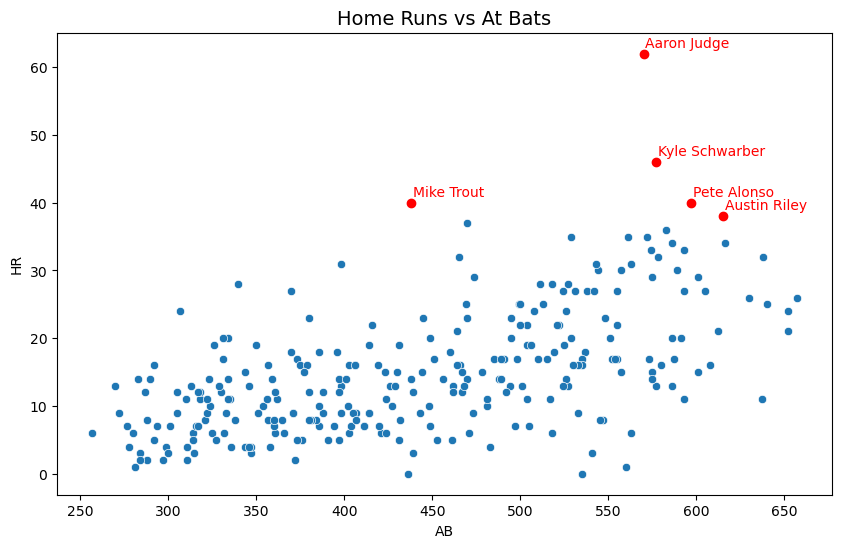

In [75]:
# scatterplot of home runs vs at bats
fig, ax = plt.subplots(figsize=(10,6))
top_5 = bat_df[['Name','HR']].sort_values(by='HR',ascending=False).head(5)
players = top_5['Name']

sns.scatterplot(data=bat_df,x='AB',y='HR')
ax.set_title('Home Runs vs At Bats',fontsize=14)

for player_name in players:
    player = bat_df.loc[bat_df['Name'] == player_name]
    
    if not player.empty:
        ab = player['AB']
        homerun = player['HR']
        
        ax.annotate(player_name,xy=(ab+1,homerun+1),color='red',fontsize=10)
        ax.scatter(ab,homerun,color='red')

In [111]:
# qualified batters with 140+ wRC+
bat_df[['Name','Team','Age','wRC+']].loc[(bat_df['PA']>=502)&(bat_df['wRC+']>=140)].sort_values(by='wRC+',ascending=False,ignore_index=True)

,Name,Team,Age,wRC+
0,Aaron Judge,NYY,30,207
1,Yordan Alvarez,HOU,25,185
2,Paul Goldschmidt,STL,34,177
3,Jose Altuve,HOU,32,164
4,Freddie Freeman,LAD,32,157
5,Manny Machado,SDP,29,152
6,Nolan Arenado,STL,31,151
7,Yandy Diaz,TBR,30,146
8,Julio Rodriguez,SEA,21,146
9,Juan Soto,- - -,23,145


In [116]:
# qualified batters with an OPS over .850
bat_df[['Name','Team','Age','OPS']].loc[(bat_df['PA']>=502)&(bat_df['OPS']>=.85)].sort_values(by='OPS',ascending=False,ignore_index=True)

,Name,Team,Age,OPS
0,Aaron Judge,NYY,30,1.111
1,Yordan Alvarez,HOU,25,1.019
2,Paul Goldschmidt,STL,34,0.981
3,Jose Altuve,HOU,32,0.921
4,Freddie Freeman,LAD,32,0.918
5,Manny Machado,SDP,29,0.898
6,Nolan Arenado,STL,31,0.891
7,Rafael Devers,BOS,25,0.879
8,Austin Riley,ATL,25,0.878
9,Shohei Ohtani,LAA,27,0.875


In [117]:
# batters with 20+ stolen bases
bat_df[['Name','Team','Age','SB']].loc[bat_df['SB']>=20].sort_values(by='SB',ascending=False,ignore_index=True)

,Name,Team,Age,SB
0,Jon Berti,MIA,32,41
1,Jorge Mateo,BAL,27,35
2,Cedric Mullins II,BAL,27,34
3,Tommy Edman,STL,27,32
4,Randy Arozarena,TBR,27,32
5,Bobby Witt Jr.,KCR,22,30
6,Ronald Acuna Jr.,ATL,24,29
7,Trea Turner,LAD,29,27
8,Julio Rodriguez,SEA,21,25
9,Kyle Tucker,HOU,25,25


In [118]:
# HR, OPS, wRC+ for players with 6+ WAR
bat_df[['Name','Team','Age','HR','OPS','wRC+','WAR']].loc[bat_df['WAR']>=6].sort_values(by='WAR',ascending=False,ignore_index=True)

,Name,Team,Age,HR,OPS,wRC+,WAR
0,Aaron Judge,NYY,30,62,1.111,207,11.5
1,Manny Machado,SDP,29,32,0.898,152,7.4
2,Nolan Arenado,STL,31,30,0.891,151,7.3
3,Paul Goldschmidt,STL,34,35,0.981,177,7.1
4,Freddie Freeman,LAD,32,21,0.918,157,7.1
5,Francisco Lindor,NYM,28,26,0.788,127,6.8
6,Yordan Alvarez,HOU,25,37,1.019,185,6.7
7,Jose Altuve,HOU,32,28,0.921,164,6.6
8,Mookie Betts,LAD,29,35,0.873,144,6.5
9,J.T. Realmuto,PHI,31,22,0.820,128,6.5


In [130]:
# qualified batters with strikeout rate over 25%
bat_adv_df[['Name','Team','Age','K%']].loc[(bat_adv_df['PA']>=502)&(bat_adv_df['K%']>=.25)].sort_values(by='K%',ascending=False,ignore_index=True)

,Name,Team,Age,K%
0,Patrick Wisdom,CHC,30,0.343
1,Luke Voit,- - -,31,0.315
2,Eugenio Suarez,SEA,30,0.312
3,Kyle Schwarber,PHI,29,0.299
4,Trent Grisham,SDP,25,0.286
5,Teoscar Hernandez,TOR,29,0.284
6,Adolis Garcia,TEX,29,0.279
7,Jorge Mateo,BAL,27,0.276
8,Matt Chapman,TOR,29,0.274
9,Cody Bellinger,LAD,26,0.273


In [140]:
# top 10 walk rate among qualified batters
bat_adv_df[['Name','Team','Age','BB%']].loc[bat_adv_df['PA']>=502].sort_values(by='BB%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,BB%
0,Juan Soto,- - -,23,0.203
1,Aaron Judge,NYY,30,0.159
2,Max Muncy,LAD,31,0.159
3,Jesse Winker,SEA,28,0.154
4,Yandy Diaz,TBR,30,0.140
5,Carlos Santana,- - -,36,0.140
6,Yordan Alvarez,HOU,25,0.139
7,Alex Bregman,HOU,28,0.133
8,Christian Yelich,MIL,30,0.131
9,Kyle Schwarber,PHI,29,0.129


In [143]:
# top 10 BB/K ratio among qualified batters
bat_adv_df[['Name','Team','Age','BB/K']].loc[bat_adv_df['PA']>=502].sort_values(by='BB/K',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,BB/K
0,Juan Soto,- - -,23,1.41
1,Yandy Diaz,TBR,30,1.30
2,Luis Arraez,MIN,25,1.16
3,Alex Bregman,HOU,28,1.13
4,Alejandro Kirk,TOR,23,1.09
5,Steven Kwan,CLE,24,1.03
6,DJ LeMahieu,NYY,33,0.94
7,J.P. Crawford,SEA,27,0.85
8,Jose Ramirez,CLE,29,0.84
9,Freddie Freeman,LAD,32,0.82


In [154]:
# top 10 swinging strike percentage among qualified batters
bat_adv_df[['Name','Team','Age','SwStr%']].loc[bat_adv_df['PA']>=502].sort_values(by='SwStr%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,SwStr%
0,Luke Voit,- - -,31,0.187
1,Javier Baez,DET,29,0.186
2,Nick Castellanos,PHI,30,0.170
3,Adolis Garcia,TEX,29,0.168
4,Patrick Wisdom,CHC,30,0.161
5,Jeremy Pena,HOU,24,0.157
6,Teoscar Hernandez,TOR,29,0.156
7,Ryan Mountcastle,BAL,25,0.155
8,Jorge Mateo,BAL,27,0.154
9,Nelson Cruz,WSN,41,0.150


In [150]:
# lowest 10 outside swing percentage among qualified batters
bat_adv_df[['Name','Team','Age','O-Swing%']].loc[bat_adv_df['PA']>=502].sort_values(by='O-Swing%',ignore_index=True).head(10)

,Name,Team,Age,O-Swing%
0,Juan Soto,- - -,23,0.199
1,Max Muncy,LAD,31,0.212
2,Alex Bregman,HOU,28,0.218
3,Jesse Winker,SEA,28,0.223
4,Josh Rojas,ARI,28,0.225
5,Matt Chapman,TOR,29,0.229
6,Trent Grisham,SDP,25,0.230
7,Yandy Diaz,TBR,30,0.231
8,Steven Kwan,CLE,24,0.233
9,Myles Straw,CLE,27,0.234


In [151]:
# top 10 zone contact percentage among qualified batters
bat_adv_df[['Name','Team','Age','Z-Contact%']].loc[bat_adv_df['PA']>=502].sort_values(by='Z-Contact%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,Z-Contact%
0,Luis Arraez,MIN,25,0.960
1,Miguel Rojas,MIA,33,0.959
2,Isiah Kiner-Falefa,NYY,27,0.956
3,Steven Kwan,CLE,24,0.954
4,Myles Straw,CLE,27,0.939
5,Mookie Betts,LAD,29,0.939
6,Nico Hoerner,CHC,25,0.939
7,Yuli Gurriel,HOU,38,0.937
8,Tony Kemp,OAK,30,0.936
9,Alex Verdugo,BOS,26,0.933


In [152]:
# top 10 hard hit percentage among qualified batters
bat_adv_df[['Name','Team','Age','Hard%']].loc[bat_adv_df['PA']>=502].sort_values(by='Hard%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,Hard%
0,Aaron Judge,NYY,30,0.480
1,Yordan Alvarez,HOU,25,0.442
2,Teoscar Hernandez,TOR,29,0.438
3,Max Muncy,LAD,31,0.410
4,Rowdy Tellez,MIL,27,0.404
5,Matt Chapman,TOR,29,0.402
6,Ryan McMahon,COL,27,0.396
7,Austin Riley,ATL,25,0.395
8,Adolis Garcia,TEX,29,0.393
9,Matt Olson,ATL,28,0.393


**Pitching Stats**

**Starting Pitchers**

In [119]:
# qualified starting pitchers with a sub-3.00 ERA
sp_df[['Name','Team','Age','ERA']].loc[(sp_df['IP']>=162)&(sp_df['ERA']<3.0)].sort_values(by='ERA',ignore_index=True)

,Name,Team,Age,ERA
0,Justin Verlander,HOU,39,1.75
1,Julio Urias,LAD,25,2.16
2,Dylan Cease,CHW,26,2.20
3,Alek Manoah,TOR,24,2.24
4,Sandy Alcantara,MIA,26,2.28
5,Shohei Ohtani,LAA,27,2.33
6,Max Fried,ATL,28,2.48
7,Shane McClanahan,TBR,25,2.54
8,Zac Gallen,ARI,26,2.54
9,Tyler Anderson,LAD,32,2.57


In [120]:
# starting pitchers with 200+ strikeouts
sp_df[['Name','Team','Age','SO']].loc[sp_df['SO']>=200].sort_values(by='SO',ascending=False,ignore_index=True)

,Name,Team,Age,SO
0,Gerrit Cole,NYY,31,257
1,Corbin Burnes,MIL,27,243
2,Carlos Rodon,SFG,29,237
3,Aaron Nola,PHI,29,235
4,Dylan Cease,CHW,26,227
5,Shohei Ohtani,LAA,27,219
6,Robbie Ray,SEA,30,212
7,Sandy Alcantara,MIA,26,207
8,Kevin Gausman,TOR,31,205
9,Charlie Morton,ATL,38,205


In [121]:
# starting pitchers with 15+ wins
sp_df[['Name','Team','Age','W']].loc[sp_df['W']>=15].sort_values(by='W',ascending=False,ignore_index=True)

,Name,Team,Age,W
0,Kyle Wright,ATL,26,21
1,Justin Verlander,HOU,39,18
2,Framber Valdez,HOU,28,17
3,Julio Urias,LAD,25,17
4,Yu Darvish,SDP,35,16
5,Alek Manoah,TOR,24,16
6,Tony Gonsolin,LAD,28,16
7,Shohei Ohtani,LAA,27,15
8,Logan Webb,SFG,25,15
9,Tyler Anderson,LAD,32,15


In [123]:
# qualified starting pitchers with a sub-1.00 WHIP
sp_df[['Name','Team','Age','WHIP']].loc[(sp_df['IP']>=162)&(sp_df['WHIP']<1)].sort_values(by='WHIP',ignore_index=True)

,Name,Team,Age,WHIP
0,Justin Verlander,HOU,39,0.83
1,Zac Gallen,ARI,26,0.91
2,Shane McClanahan,TBR,25,0.93
3,Yu Darvish,SDP,35,0.95
4,Triston McKenzie,CLE,24,0.95
5,Aaron Nola,PHI,29,0.96
6,Julio Urias,LAD,25,0.96
7,Corbin Burnes,MIL,27,0.97
8,Sandy Alcantara,MIA,26,0.98
9,Alek Manoah,TOR,24,0.99


In [156]:
# top 10 ERA- among qualified starting pitchers
sp_adv_df[['Name','Team','Age','ERA-']].loc[(sp_adv_df['IP']>=162)].sort_values(by='ERA-',ignore_index=True).head(10)

,Name,Team,Age,ERA-
0,Justin Verlander,HOU,39,45
1,Julio Urias,LAD,25,55
2,Dylan Cease,CHW,26,56
3,Alek Manoah,TOR,24,58
4,Sandy Alcantara,MIA,26,58
5,Shohei Ohtani,LAA,27,59
6,Max Fried,ATL,28,60
7,Zac Gallen,ARI,26,62
8,Tyler Anderson,LAD,32,65
9,Shane McClanahan,TBR,25,69


In [160]:
# top 10 K/9 rate among qualified starting pitchers
sp_adv_df[['Name','Team','Age','K/9']].loc[(sp_adv_df['IP']>=162)].sort_values(by='K/9',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,K/9
0,Carlos Rodon,SFG,29,11.98
1,Shohei Ohtani,LAA,27,11.87
2,Gerrit Cole,NYY,31,11.53
3,Dylan Cease,CHW,26,11.10
4,Corbin Burnes,MIL,27,10.83
5,Charlie Morton,ATL,38,10.73
6,Kevin Gausman,TOR,31,10.56
7,Shane McClanahan,TBR,25,10.50
8,Aaron Nola,PHI,29,10.32
9,Robbie Ray,SEA,30,10.10


In [161]:
# top 10 K/BB ratio among qualified starting pitchers
sp_adv_df[['Name','Team','Age','K/BB']].loc[(sp_adv_df['IP']>=162)].sort_values(by='K/BB',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,K/BB
0,Aaron Nola,PHI,29,8.10
1,Kevin Gausman,TOR,31,7.32
2,Corey Kluber,TBR,36,6.62
3,Justin Verlander,HOU,39,6.38
4,Shane Bieber,CLE,27,5.50
5,Yu Darvish,SDP,35,5.32
6,Max Fried,ATL,28,5.31
7,Gerrit Cole,NYY,31,5.14
8,Shane McClanahan,TBR,25,5.11
9,Shohei Ohtani,LAA,27,4.98


In [162]:
# top 10 LOB% among qualified starting pitchers
sp_adv_df[['Name','Team','Age','LOB%']].loc[(sp_adv_df['IP']>=162)].sort_values(by='LOB%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,LOB%
0,Julio Urias,LAD,25,0.866
1,Shohei Ohtani,LAA,27,0.831
2,Alek Manoah,TOR,24,0.826
3,Dylan Cease,CHW,26,0.823
4,Robbie Ray,SEA,30,0.812
5,Justin Verlander,HOU,39,0.805
6,Shane McClanahan,TBR,25,0.805
7,Triston McKenzie,CLE,24,0.803
8,Joe Musgrove,SDP,29,0.798
9,Jose Urquidy,HOU,27,0.789


In [163]:
# top 10 groundball percentage among qualified starting pitchers
sp_adv_df[['Name','Team','Age','GB%']].loc[(sp_adv_df['IP']>=162)].sort_values(by='GB%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,GB%
0,Framber Valdez,HOU,28,0.665
1,Logan Webb,SFG,25,0.567
2,Kyle Wright,ATL,26,0.556
3,Sandy Alcantara,MIA,26,0.534
4,Martin Perez,TEX,31,0.514
5,Max Fried,ATL,28,0.512
6,Shane McClanahan,TBR,25,0.502
7,Chris Bassitt,NYM,33,0.488
8,Shane Bieber,CLE,27,0.482
9,German Marquez,COL,27,0.476


In [165]:
# top 10 soft hit percentage among qualified starting pitchers
sp_adv_df[['Name','Team','Age','Soft%']].loc[(sp_adv_df['IP']>=162)].sort_values(by='Soft%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,Soft%
0,Chris Bassitt,NYM,33,0.221
1,Sandy Alcantara,MIA,26,0.215
2,Julio Urias,LAD,25,0.214
3,Justin Verlander,HOU,39,0.213
4,Tyler Anderson,LAD,32,0.209
5,Shohei Ohtani,LAA,27,0.203
6,Max Fried,ATL,28,0.199
7,Joe Musgrove,SDP,29,0.198
8,Jose Quintana,- - -,33,0.189
9,Miles Mikolas,STL,33,0.186


In [166]:
# top 10 hard hit percentage among qualifed starting pitchers
sp_adv_df[['Name','Team','Age','Hard%']].loc[(sp_adv_df['IP']>=162)].sort_values(by='Hard%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,Hard%
0,Kyle Freeland,COL,29,0.366
1,German Marquez,COL,27,0.361
2,Logan Gilbert,SEA,25,0.354
3,Nick Pivetta,BOS,29,0.342
4,Triston McKenzie,CLE,24,0.335
5,Shane Bieber,CLE,27,0.335
6,Robbie Ray,SEA,30,0.332
7,Cole Irvin,OAK,28,0.321
8,Jameson Taillon,NYY,30,0.317
9,Corbin Burnes,MIL,27,0.316


In [167]:
# top 10 HR/9 rate among qualified starting pitchers
sp_df[['Name','Team','Age','HR/9']].loc[(sp_df['IP']>=162)].sort_values(by='HR/9',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,HR/9
0,Jose Urquidy,HOU,27,1.59
1,Robbie Ray,SEA,30,1.52
2,Jose Berrios,TOR,28,1.52
3,German Marquez,COL,27,1.49
4,Gerrit Cole,NYY,31,1.48
5,Marco Gonzales,SEA,30,1.48
6,Charlie Morton,ATL,38,1.47
7,Nick Pivetta,BOS,29,1.35
8,Jameson Taillon,NYY,30,1.32
9,Jordan Lyles,BAL,31,1.31


In [185]:
# ERA, FIP, SIERA, ERA- for top 15 ERA among qualified starting pitchers
sp_adv_df[['Name','Team','Age','ERA','FIP','SIERA','ERA-']].loc[(sp_adv_df['IP']>=162)].sort_values(by='ERA',ignore_index=True).head(15)

,Name,Team,Age,ERA,FIP,SIERA,ERA-
0,Justin Verlander,HOU,39,1.75,2.49,3.09,45
1,Julio Urias,LAD,25,2.16,3.71,3.66,55
2,Dylan Cease,CHW,26,2.20,3.10,3.48,56
3,Alek Manoah,TOR,24,2.24,3.35,3.85,58
4,Sandy Alcantara,MIA,26,2.28,2.99,3.42,58
5,Shohei Ohtani,LAA,27,2.33,2.40,2.73,59
6,Max Fried,ATL,28,2.48,2.70,3.31,60
7,Shane McClanahan,TBR,25,2.54,3.00,2.82,69
8,Zac Gallen,ARI,26,2.54,3.05,3.32,62
9,Tyler Anderson,LAD,32,2.57,3.31,4.04,65


In [186]:
# strikeouts, walks, K/9, K/BB for top 15 strikeouts among starting pitchers
sp_df[['Name','Team','Age','IP','SO','BB','K/9','K/BB']].sort_values(by='SO',ascending=False,ignore_index=True).head(15)

,Name,Team,Age,IP,SO,BB,K/9,K/BB
0,Gerrit Cole,NYY,31,200.2,257,50,11.53,5.14
1,Corbin Burnes,MIL,27,202.0,243,51,10.83,4.76
2,Carlos Rodon,SFG,29,178.0,237,52,11.98,4.56
3,Aaron Nola,PHI,29,205.0,235,29,10.32,8.10
4,Dylan Cease,CHW,26,184.0,227,78,11.10,2.91
5,Shohei Ohtani,LAA,27,166.0,219,44,11.87,4.98
6,Robbie Ray,SEA,30,189.0,212,62,10.10,3.42
7,Sandy Alcantara,MIA,26,228.2,207,50,8.15,4.14
8,Kevin Gausman,TOR,31,174.2,205,28,10.56,7.32
9,Charlie Morton,ATL,38,172.0,205,63,10.73,3.25


In [188]:
# top 10 WAR among starting pitchers
sp_df[['Name','Team','Age','WAR']].sort_values(by='WAR',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,WAR
0,Aaron Nola,PHI,29,6.3
1,Carlos Rodon,SFG,29,6.2
2,Justin Verlander,HOU,39,6.1
3,Kevin Gausman,TOR,31,5.7
4,Sandy Alcantara,MIA,26,5.7
5,Shohei Ohtani,LAA,27,5.6
6,Max Fried,ATL,28,5.0
7,Shane Bieber,CLE,27,4.9
8,Spencer Strider,ATL,23,4.9
9,Corbin Burnes,MIL,27,4.6


**Relief Pitchers**

In [168]:
# relief pitchers with a sub-2.00 ERA
rp_df[['Name','Team','Age','ERA']].loc[(rp_df['ERA']<2)].sort_values(by='ERA',ignore_index=True)

,Name,Team,Age,ERA
0,Yency Almonte,LAD,28,1.02
1,Evan Phillips,LAD,27,1.14
2,Ryne Stanek,HOU,30,1.15
3,Ryan Helsley,STL,27,1.25
4,Edwin Diaz,NYM,28,1.31
5,Emmanuel Clase,CLE,24,1.36
6,Cionel Perez,BAL,26,1.40
7,Anthony Bass,- - -,34,1.54
8,Jason Adam,TBR,30,1.56
9,Erik Swanson,SEA,28,1.68


In [169]:
# relief pitchers with a sub-1.00 WHIP
rp_df[['Name','Team','Age','WHIP']].loc[(rp_df['WHIP']<1)].sort_values(by='WHIP',ignore_index=True)

,Name,Team,Age,WHIP
0,Emmanuel Clase,CLE,24,0.73
1,Ryan Helsley,STL,27,0.74
2,Evan Phillips,LAD,27,0.76
3,Jason Adam,TBR,30,0.76
4,Paul Sewald,SEA,32,0.77
5,Yency Almonte,LAD,28,0.79
6,Edwin Diaz,NYM,28,0.84
7,Andres Munoz,SEA,23,0.89
8,Eli Morgan,CLE,26,0.89
9,Ryan Pressly,HOU,33,0.89


In [171]:
# top 10 saves
rp_df[['Name','Team','Age','SV']].sort_values(by='SV',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,SV
0,Emmanuel Clase,CLE,24,42
1,Kenley Jansen,ATL,34,41
2,Liam Hendriks,CHW,33,37
3,Josh Hader,- - -,28,36
4,Jordan Romano,TOR,29,36
5,Daniel Bard,COL,37,34
6,Ryan Pressly,HOU,33,33
7,Edwin Diaz,NYM,28,32
8,Taylor Rogers,- - -,31,31
9,Gregory Soto,DET,27,30


In [174]:
# top 10 ERA- among relief pitchers
rp_adv_df[['Name','Team','Age','ERA-']].sort_values(by='ERA-',ignore_index=True).head(10)

,Name,Team,Age,ERA-
0,Yency Almonte,LAD,28,26
1,Evan Phillips,LAD,27,29
2,Ryne Stanek,HOU,30,30
3,Ryan Helsley,STL,27,32
4,Edwin Diaz,NYM,28,35
5,Emmanuel Clase,CLE,24,35
6,Cionel Perez,BAL,26,36
7,Daniel Bard,COL,37,39
8,Anthony Bass,- - -,34,39
9,Jason Adam,TBR,30,42


In [177]:
# top 10 K/9 rate among relief pitchers
rp_df[['Name','Team','Age','K/9']].sort_values(by='K/9',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,K/9
0,Edwin Diaz,NYM,28,17.13
1,Josh Hader,- - -,28,14.58
2,James Karinchak,CLE,26,14.31
3,Jose Alvarado,PHI,27,14.29
4,Devin Williams,MIL,27,14.24
5,Andres Munoz,SEA,23,13.29
6,Liam Hendriks,CHW,33,13.27
7,Bryan Abreu,HOU,25,13.13
8,Alex Vesia,LAD,26,13.09
9,Ryan Helsley,STL,27,13.08


In [178]:
# top 10 K/BB ratio among relief pitchers
rp_df[['Name','Team','Age','K/BB']].sort_values(by='K/BB',ascending=False).head(10)

,Name,Team,Age,K/BB
122,Chris Martin,- - -,36,14.80
94,Joe Mantiply,ARI,31,10.17
5,Emmanuel Clase,CLE,24,7.70
9,Erik Swanson,SEA,28,7.00
4,Edwin Diaz,NYM,28,6.56
57,Andres Munoz,SEA,23,6.40
21,A.J. Minter,ATL,28,6.27
81,Zach Pop,- - -,25,6.25
276,Taylor Clarke,KCR,29,6.00
199,Joe Jimenez,DET,27,5.92


In [179]:
# top 10 LOB% among relief pitchers
rp_adv_df[['Name','Team','Age','LOB%']].sort_values(by='LOB%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,LOB%
0,Yency Almonte,LAD,28,0.959
1,Ryan Helsley,STL,27,0.934
2,David Price,LAD,36,0.933
3,Ryne Stanek,HOU,30,0.919
4,Edwin Diaz,NYM,28,0.904
5,Anthony Bass,- - -,34,0.895
6,Jason Adam,TBR,30,0.894
7,Jhoan Duran,MIN,24,0.893
8,Drew Smith,NYM,28,0.891
9,Adam Ottavino,NYM,36,0.891


In [182]:
# top 10 hard hit percentage among relief pitchers
rp_adv_df[['Name','Team','Age','Hard%']].sort_values(by='Hard%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,Hard%
0,Cole Sulser,MIA,32,0.421
1,Dinelson Lamet,- - -,29,0.420
2,Robert Stephenson,- - -,29,0.407
3,Ian Kennedy,ARI,37,0.402
4,Alex Colome,COL,33,0.400
5,T.J. McFarland,STL,33,0.397
6,Trent Thornton,TOR,28,0.396
7,Jake Bird,COL,26,0.394
8,Jake McGee,- - -,35,0.381
9,Noe Ramirez,ARI,32,0.378


In [183]:
# top 10 HR/9 rate among relief pitchers
rp_df[['Name','Team','Age','HR/9']].sort_values(by='HR/9',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,HR/9
0,Mike Mayers,LAA,30,2.66
1,Kirk McCarty,CLE,26,2.63
2,Dauri Moreta,CIN,26,2.35
3,Craig Stammen,SDP,38,1.99
4,Ian Kennedy,ARI,37,1.97
5,Caleb Smith,ARI,30,1.80
6,Austin Pruitt,OAK,32,1.79
7,Phil Bickford,LAD,26,1.77
8,Drew Smith,NYM,28,1.76
9,Brandon Hughes,CHC,26,1.72


In [189]:
# ERA, FIP, SIERA, ERA- for top 15 ERA among relief pitchers
rp_adv_df[['Name','Team','Age','ERA','FIP','SIERA','ERA-']].sort_values(by='ERA',ignore_index=True).head(15)

,Name,Team,Age,ERA,FIP,SIERA,ERA-
0,Yency Almonte,LAD,28,1.02,3.17,3.25,26
1,Evan Phillips,LAD,27,1.14,1.94,2.34,29
2,Ryne Stanek,HOU,30,1.15,3.02,3.85,30
3,Ryan Helsley,STL,27,1.25,2.34,2.02,32
4,Edwin Diaz,NYM,28,1.31,0.90,1.11,35
5,Emmanuel Clase,CLE,24,1.36,1.98,1.95,35
6,Cionel Perez,BAL,26,1.40,2.80,3.48,36
7,Anthony Bass,- - -,34,1.54,3.00,3.11,39
8,Jason Adam,TBR,30,1.56,2.86,2.57,42
9,Erik Swanson,SEA,28,1.68,1.85,2.19,45


In [190]:
# strikeouts, walks, K/9, K/BB for top 15 strikeouts among relief pitchers
rp_df[['Name','Team','Age','IP','SO','BB','K/9','K/BB']].sort_values(by='SO',ascending=False,ignore_index=True).head(15)

,Name,Team,Age,IP,SO,BB,K/9,K/BB
0,Edwin Diaz,NYM,28,62.0,118,18,17.13,6.56
1,Devin Williams,MIL,27,60.2,96,30,14.24,3.20
2,Andres Munoz,SEA,23,65.0,96,15,13.29,6.40
3,A.J. Minter,ATL,28,70.0,94,15,12.09,6.27
4,Ryan Helsley,STL,27,64.2,94,20,13.08,4.70
5,Tanner Scott,MIA,27,62.2,90,46,12.93,1.96
6,Brock Burke,TEX,25,82.1,90,24,9.84,3.75
7,Jhoan Duran,MIN,24,67.2,89,16,11.84,5.56
8,Felix Bautista,BAL,27,65.2,88,23,12.06,3.83
9,Bryan Abreu,HOU,25,60.1,88,26,13.13,3.38


**Statcast**